Model Degree 1 details saved.
Model Degree 2 details saved.
Model Degree 3 details saved.
Completed model evaluations and outputs.


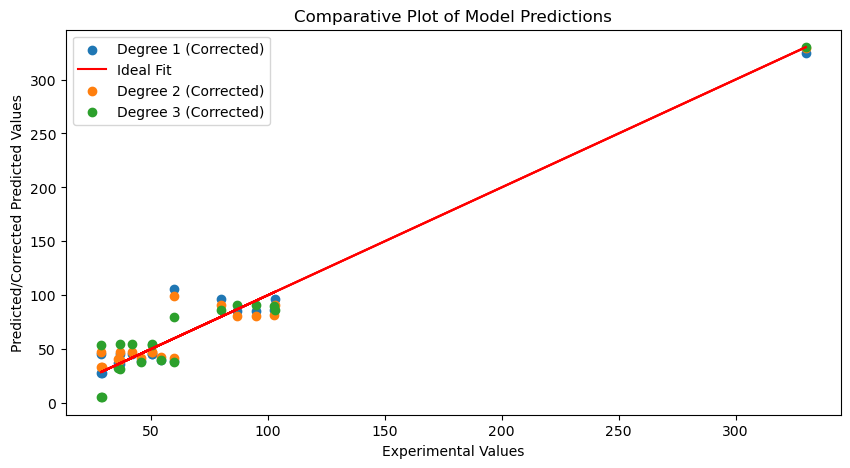

Model Degree 1 details saved.
Model Degree 2 details saved.
Model Degree 3 details saved.


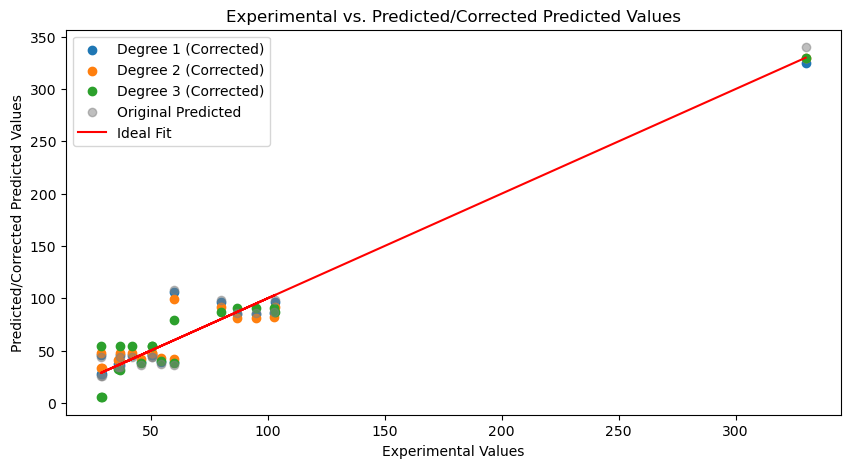

Top 3 Models:
Degree: 1, Train R^2: 0.9575, Test R^2: 0.5881, RMSE: 11.7813
Equation: y = 0.9428x + 4.2042
Degree: 2, Train R^2: 0.9603, Test R^2: 0.6975, RMSE: 10.0962
Equation: y = 0.7155x + 15.0364
Degree: 3, Train R^2: 0.9734, Test R^2: 0.0393, RMSE: 17.9935
Equation: y = 5.2739x + -101.8055
Completed model evaluations and outputs.


In [42]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Load data from Excel file
file_path = 'experimental_data.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, names=['Predicted', 'Experimental'], skiprows=1)

# Optionally load new predictions from an external file
new_pred_path = 'new_predictions.xlsx'
new_predictions_df = pd.read_excel(new_pred_path)

# Define bin edges for groups
bins = [0, 10, 50, 100, 500, 1000]

def categorize_data(data, bins):
    categories = pd.cut(data, bins=bins, labels=[1, 2, 3, 4, 5], include_lowest=True)
    return categories

df['Predicted_Group'] = categorize_data(df['Predicted'], bins)
df['Experimental_Group'] = categorize_data(df['Experimental'], bins)

df['Fold_Difference'] = df.apply(lambda x: max(x['Predicted']/x['Experimental'], x['Experimental']/x['Predicted']), axis=1)
df['Value_Difference'] = abs(df['Predicted'] - df['Experimental'])

group_outliers = (abs(df['Predicted_Group'].cat.codes - df['Experimental_Group'].cat.codes) > 2)
value_outliers = ((df['Predicted'] > 20) & (df['Fold_Difference'] > 2)) | ((df['Predicted'] <= 20) & (df['Value_Difference'] > 10))
total_outliers = group_outliers | value_outliers

outliers = df[total_outliers]
df = df.drop(df[total_outliers].index)

X = df[['Predicted']]
y = df['Experimental']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

top_models = []

for degree in range(1, 4):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    top_models.append({
        'degree': degree,
        'model': model,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'rmse': rmse,
        'equation': f'y = {model.named_steps["linearregression"].coef_[1]:.4f}x + {model.named_steps["linearregression"].intercept_:.4f}'
    })

# Select the best model based on test R^2
best_model_info = sorted(top_models, key=lambda x: x['test_r2'], reverse=True)[0]
best_model = best_model_info['model']

# Apply the best model to new prediction values
new_pred_corrected = best_model.predict(new_predictions_df[['Predicted']])
new_predictions_df['Corrected Predicted'] = new_pred_corrected

# Output the experimental vs predicted vs corrected predicted values to a tab-separated file
df['Corrected Predicted'] = best_model.predict(X)
df[['Experimental', 'Predicted', 'Corrected Predicted']].to_csv('experimental_predicted_corrected.tsv', sep='\t', index=False)

# Output outliers to an Excel file
outliers.to_excel('outliers.xlsx', index=False)

# Output each model's performance in separate Excel files
with pd.ExcelWriter('model_performance_details.xlsx') as writer:
    for i, model_info in enumerate(top_models):
        model_df = pd.DataFrame({
            'Experimental': y,
            'Predicted': df['Predicted'],
            'Corrected Predicted': model_info['model'].predict(X),
            'Train R^2': model_info['train_r2'],
            'Test R^2': model_info['test_r2'],
            'RMSE': model_info['rmse'],
            'Equation': model_info['equation']
        })
        model_df.to_excel(writer, sheet_name=f'Model_{model_info["degree"]}_Details')
        print(f"Model Degree {model_info['degree']} details saved.")

# Save new predictions with corrections to Excel
new_predictions_df.to_excel('new_predictions_corrected.xlsx', index=False)

print("Completed model evaluations and outputs.")

# Visualize results and generate Excel report
with pd.ExcelWriter('comprehensive_model_performance.xlsx') as writer:
    plt.figure(figsize=(10, 5))
    for model_info in top_models:
        y_pred = model_info['model'].predict(X)
        plt.scatter(y, y_pred, label=f'Degree {model_info["degree"]} (Corrected)')
        plt.plot(y, y, 'r-', label='Ideal Fit' if model_info['degree'] == 1 else "")
        
        # Save model results to Excel
        results_df = pd.DataFrame({
            'Experimental': y,
            'Predicted': df['Predicted'],
            'Corrected Predicted': y_pred,
            'Train R^2': model_info['train_r2'],
            'Test R^2': model_info['test_r2'],
            'RMSE': model_info['rmse'],
            'Equation': model_info['equation']
        })
        results_df.to_excel(writer, sheet_name=f'Model_{model_info["degree"]}_Details')
    
    plt.xlabel('Experimental Values')
    plt.ylabel('Predicted/Corrected Predicted Values')
    plt.legend()
    plt.title('Comparative Plot of Model Predictions')
    plt.show()

# Output outliers to an Excel file
outliers.to_excel('outliers.xlsx', index=False)

# Output each model's performance in separate Excel files
with pd.ExcelWriter('model_performance_details.xlsx') as writer:
    for i, model_info in enumerate(top_models):
        model_df = pd.DataFrame({
            'Experimental': y,
            'Predicted': df['Predicted'],
            'Corrected Predicted': model_info['model'].predict(X),
            'Train R^2': model_info['train_r2'],
            'Test R^2': model_info['test_r2'],
            'RMSE': model_info['rmse'],
            'Equation': model_info['equation']
        })
        model_df.to_excel(writer, sheet_name=f'Model_{model_info["degree"]}_Details')
        print(f"Model Degree {model_info['degree']} details saved.")

# Save new predictions with corrections to Excel
new_predictions_df.to_excel('new_predictions_corrected.xlsx', index=False)

# Save details and results
with pd.ExcelWriter('enhanced_model_performance.xlsx') as writer:
    for i, model in enumerate(top_models):
        results_df = pd.DataFrame({
            'Experimental': y,
            'Predicted': df['Predicted'],
            'Corrected Predicted': model['model'].predict(X),
            'Train R^2': model['train_r2'],
            'Test R^2': model['test_r2'],
            'RMSE': model['rmse'],
            'Equation': model['equation']
        })
        results_df.to_excel(writer, sheet_name=f'Model_{model["degree"]}_Details')

# Save details to Excel
with pd.ExcelWriter('model_performance_summary.xlsx') as writer:
    for i, model in enumerate(top_models):
        results_df = pd.DataFrame({
            'Experimental': y,
            'Predicted': df['Predicted'],
            'Corrected Predicted': model['model'].predict(X)
        })
        results_df.to_excel(writer, sheet_name=f'Model_{model["degree"]}_Results') 
        
# Save details to Excel
results_df = pd.DataFrame({
    'Experimental': df['Experimental'],
    'Predicted': df['Predicted'],
    'Corrected Predicted': y_pred
})
results_df.to_excel('best_model_performance.xlsx', index=False)

# Visualize results
plt.figure(figsize=(10, 5))
for model_info in top_models:
    y_pred = model_info['model'].predict(X)
    plt.scatter(y, y_pred, label=f'Degree {model_info["degree"]} (Corrected)')
plt.scatter(y, df['Predicted'], color='grey', alpha=0.5, label='Original Predicted')
plt.plot(y, y, 'r-', label='Ideal Fit')
plt.title('Experimental vs. Predicted/Corrected Predicted Values')
plt.xlabel('Experimental Values')
plt.ylabel('Predicted/Corrected Predicted Values')
plt.legend()
plt.show()

print("Top 3 Models:")
for model in top_models:
    print(f"Degree: {model['degree']}, Train R^2: {model['train_r2']:.4f}, Test R^2: {model['test_r2']:.4f}, RMSE: {model['rmse']:.4f}")
    print(f"Equation: {model['equation']}")

print("Completed model evaluations and outputs.")
